In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [4]:
pickle_file = '321_bal_7384.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_target']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (22152, 1, 64, 64) (22152, 6)


In [5]:
c3 = []
c2 = []
c1 = []

for i in range(22152):
    categ = train_labels[i][0]
    if(categ == 3):
        c3.append(i)
    elif(categ == 2):
        c2.append(i)
    elif(categ == 1):
        c1.append(i)

print(len(c3))
print(len(c2))
print(len(c1))

7384
7384
7384


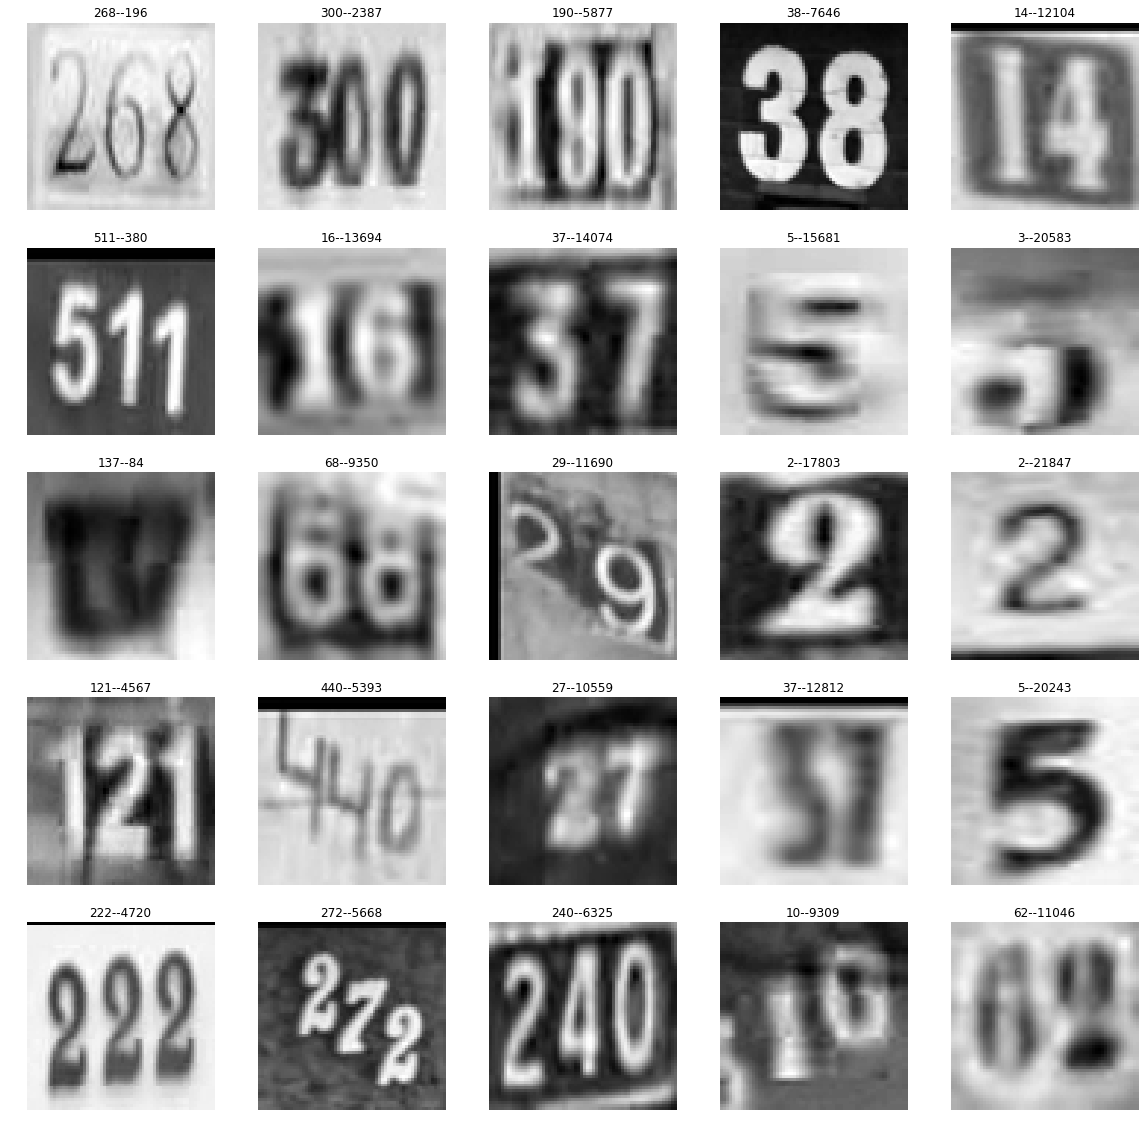

In [6]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=5, ncols=5)

im_samples = []

for row in range(5):
    for i, j in enumerate(np.sort(np.random.randint(0, train_labels.shape[0], size=5))):
        im = train_dataset[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(train_labels[j,0]):
            house_num += str(train_labels[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(80)
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(120)
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.bn5 = nn.BatchNorm2d(160)
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.bn6 = nn.BatchNorm2d(200)
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.bn7 = nn.BatchNorm2d(240)
        self.pool = nn.MaxPool2d(2, 2)
        self.FC = nn.Linear(960, 1080)
        self.bn8 = nn.BatchNorm1d(1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
        
        #for m in self.modules():
         #   if isinstance(m, nn.Conv2d):
          #      init.kaiming_normal(m.weight)
           #     m.bias.data.zero_()
            #elif isinstance(m, nn.Linear):
             #   init.kaiming_normal(m.weight)
              #  m.bias.data.zero_()
    
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        x = self.pool(self.bn7(F.relu(self.conv7(x))))
        x = x.view(-1, 960)
        x = self.bn8(F.relu(self.FC(x)))
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [10]:
net = Net()
f = open('c321_overfit_longer.pkl', 'rb')
net.load_state_dict(torch.load(f))
f.close()
net.cuda()
print("!")

!


In [11]:
print(list(net.parameters())[0][0].grad)

None


In [12]:
for param in net.parameters():
    if(param.grad is not None):
        print(param)

In [13]:
data_tensor = torch.from_numpy(train_dataset)
target_tensor = torch.from_numpy(train_labels).type(torch.LongTensor)
print(data_tensor.type(), data_tensor.size())
print(target_tensor.type(), target_tensor.size())

torch.FloatTensor torch.Size([22152, 1, 64, 64])
torch.LongTensor torch.Size([22152, 6])


In [14]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [23]:
num_epochs = 100
batch_size = 64
num_train = data_tensor.size()[0]
print(num_train)
iter_per_epoch = num_train // batch_size
print_every = 150
print(iter_per_epoch)

22152
346


In [17]:
epoch_losses = {i:[] for i in range(num_epochs)}
loss_history = []

In [18]:
net.train()
print("!")

!


In [24]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 110)

    i = 0
    rng_state = torch.get_rng_state()
    new_idxs = torch.randperm(num_train)
    
    t1 = time.time()
    for t in range(iter_per_epoch):
        batch_idxs = new_idxs[i: i+batch_size]
        i += batch_size
        X_batch = data_tensor[batch_idxs]
        Y_batch = target_tensor[batch_idxs][:,0:4]
        lenths = Y_batch[:, 0]
        bin3 = []
        bin2 = []
        bin1 = []
        for idx, lenth in enumerate(lenths):
            if (lenth == 1):
                bin1.append(idx)
            elif (lenth == 2):
                bin2.append(idx)
            elif (lenth == 3):
                bin3.append(idx)
        

        X_batch = Variable(X_batch).cuda()
        Y_batch = Variable(Y_batch).cuda()
        optimizer.zero_grad()
        outputs = net(X_batch)
        
        if bin3:
            idxs = torch.LongTensor(bin3).cuda()
            Y = Y_batch[idxs]
            lossl = objective(outputs[0][idxs], Y[:, 0])
            loss1 = objective(outputs[1][idxs], Y[:, 1])
            loss2 = objective(outputs[2][idxs], Y[:, 2])
            loss3 = objective(outputs[3][idxs], Y[:, 3])
            lossd3 = lossl + loss1 + loss2 + loss3
            lossd3.backward(retain_variables=True)
            optimizer.step()
        
        if bin2:
            optimizer.zero_grad()
            idxs = torch.LongTensor(bin2).cuda()
            Y = Y_batch[idxs]
            lossl = objective(outputs[0][idxs], Y[:, 0])
            loss1 = objective(outputs[1][idxs], Y[:, 1])
            loss2 = objective(outputs[2][idxs], Y[:, 2])
            lossd2 = lossl + loss1 + loss2
            lossd2.backward(retain_variables=True)
            optimizer.step()
        
        if bin1:
            optimizer.zero_grad()
            idxs = torch.LongTensor(bin1).cuda()
            Y = Y_batch[idxs]
            lossl = objective(outputs[0][idxs], Y[:, 0])
            loss1 = objective(outputs[1][idxs], Y[:, 1])
            lossd1 = lossl + loss1
            lossd1.backward()
            optimizer.step()
        
        optimizer.step()
        final_loss = lossd3 + lossd2 + lossd1
        
        loss_history.append(final_loss.data[0])
        epoch_losses[epoch].append(final_loss.data[0])
        
        if (t % print_every == 0):
            print('Iteration : ', t+1, ' / ', iter_per_epoch)
            print('loss : ', final_loss.data[0])
            print('loss3d : ', lossd3.data[0], 'loss2d : ', lossd2.data[0], 'loss1d : ', lossd1.data[0])
        
    t2 = time.time()
    print("time taken : ", t2-t1)
    print('-' * 110)
        

Epoch 0/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  346
loss :  3.069216728210449
loss3d :  1.11677086353302 loss2d :  1.406378984451294 loss1d :  0.5460668802261353
Iteration :  151  /  346
loss :  1.267390251159668
loss3d :  0.5735924243927002 loss2d :  0.2483816146850586 loss1d :  0.44541627168655396
Iteration :  301  /  346
loss :  1.9240120649337769
loss3d :  0.8116130828857422 loss2d :  0.6791820526123047 loss1d :  0.4332168996334076
time taken :  426.8482139110565
--------------------------------------------------------------------------------------------------------------
Epoch 1/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  346
loss :  1.125109076499939
loss3d :  0.6383737921714783 loss2d :  0.2303403913974762 loss1d :  0.2563948333263397
Iteration :  151  /  346
loss :  0.6175701022148132
loss3d :  0.27

Iteration :  1  /  346
loss :  0.14246965944766998
loss3d :  0.12396106123924255 loss2d :  0.010860665701329708 loss1d :  0.007647925987839699
Iteration :  151  /  346
loss :  0.5191720724105835
loss3d :  0.41975635290145874 loss2d :  0.06025190278887749 loss1d :  0.03916383907198906
Iteration :  301  /  346
loss :  0.43157655000686646
loss3d :  0.204415425658226 loss2d :  0.0859847217798233 loss1d :  0.14117638766765594
time taken :  412.04193210601807
--------------------------------------------------------------------------------------------------------------
Epoch 13/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  346
loss :  0.1330897957086563
loss3d :  0.05545300617814064 loss2d :  0.07651431113481522 loss1d :  0.0011224746704101562
Iteration :  151  /  346
loss :  0.15709178149700165
loss3d :  0.04762370139360428 loss2d :  0.008406427688896656 loss1d :  0.10106164962053299
Iteration :  301  /  3

Iteration :  1  /  346
loss :  0.09744269400835037
loss3d :  0.029977524653077126 loss2d :  0.06745921075344086 loss1d :  5.9604644775390625e-06
Iteration :  151  /  346
loss :  0.04737967997789383
loss3d :  0.026532888412475586 loss2d :  0.02047588862478733 loss1d :  0.0003709029988385737
Iteration :  301  /  346
loss :  0.17217515408992767
loss3d :  0.019667301326990128 loss2d :  0.14871986210346222 loss1d :  0.003787994384765625
time taken :  403.61655354499817
--------------------------------------------------------------------------------------------------------------
Epoch 25/99
--------------------------------------------------------------------------------------------------------------
Iteration :  1  /  346
loss :  0.030580533668398857
loss3d :  0.0024018818512558937 loss2d :  0.028107881546020508 loss1d :  7.077057671267539e-05


KeyboardInterrupt: 

In [25]:
f = open("what_now.pkl", "bw")
torch.save(net.state_dict(), f)
f.close()

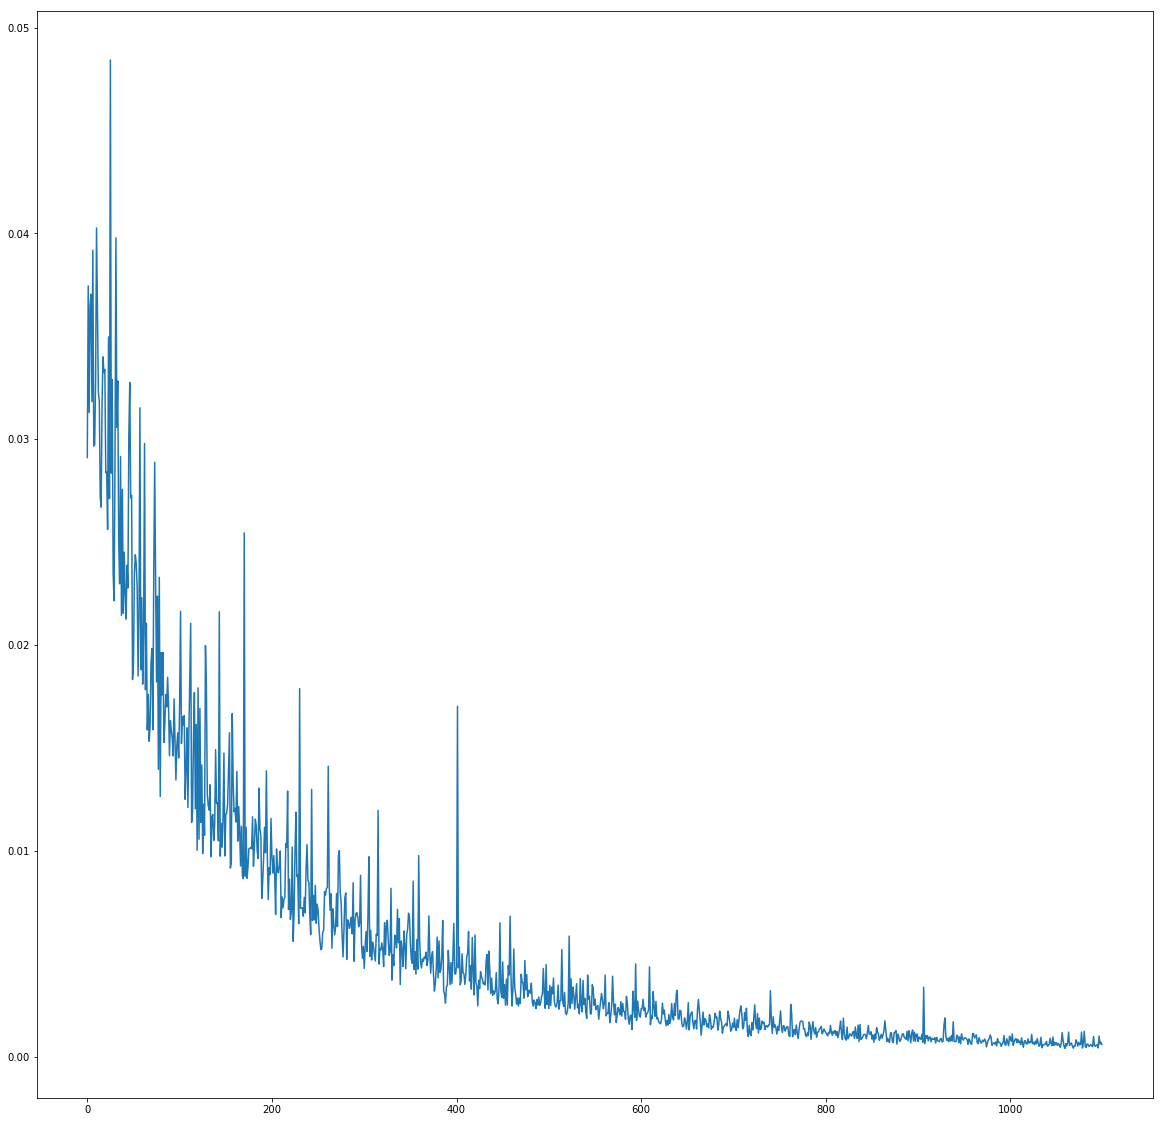

In [22]:
plt.figure()
plt.plot(loss_history)